# Detección de COVID-19 mediante imágenes de rayos-X 
Trabajo desarrollado para la asignatura SIGE - MII - ETSIIT - 19/20  
Óscar Jiménez Fernández  
yoscar@correo.ugr.es

Comprobamos que tenemos acceso a la GPU de cara a acelerar el entrenamiento de los modelos.

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Damos acceso a Drive de cara a poder obtener las imágenes que tenemos localizadas en la estructura de directorios adecuada para nuestro problema, que comentaremos a continuación.

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preparación del conjunto de datos
En esta sección leeremos cada uno de los conjuntos de imágenes de cara a poder preprocesarlas, escalándo su tamaño, balanceando cada una de las clases, y componiendo los conjuntos de entrenamiento, validación y test, además de contruir la estructura de carpetas adecuada para el proceso de aumentación de datos desde el directorio.

### Obtención del conjunto de imágenes

In [0]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_images_from_folder(folder):
    images = []
    filesnames = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        if img is not None:
            images.append(img)
            filesnames.append(filename)
    return np.array(images) / 255.0, np.array(filesnames)

def write_dataset_images_to_folder(path, dataset, filesnames):
  for idx, img in enumerate(dataset):
    img = cv2.convertScaleAbs(img, alpha=(255.0))
    cv2.imwrite(os.path.join(path , filesnames[idx]),img)


In [0]:
covid_dataset, filesnames_covid = load_images_from_folder("/content/drive/My Drive/SIGE DATASETS/covid")
healthy_dataset, filesnames_healthy = load_images_from_folder("/content/drive/My Drive/SIGE DATASETS/healthy")

In [0]:
print(covid_dataset.shape)
print(healthy_dataset.shape)

(198, 224, 224, 3)
(1341, 224, 224, 3)


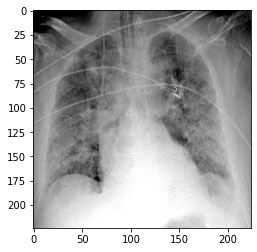

In [0]:
plt.figure()
plt.imshow(covid_dataset[0])
plt.grid(False)
plt.show()

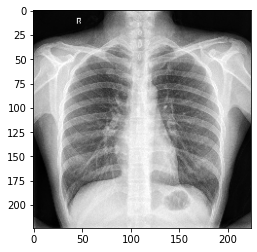

In [0]:
plt.figure()
plt.imshow(healthy_dataset[0])
plt.grid(False)
plt.show()

### Balanceo del conjunto

In [0]:
idx_healthy = np.random.choice(healthy_dataset.shape[0], covid_dataset.shape[0], replace=False)
healthy_dataset = healthy_dataset[idx_healthy]
filesnames_healthy = filesnames_healthy[idx_healthy]

In [0]:
print(covid_dataset.shape)
print(healthy_dataset.shape)

(198, 224, 224, 3)
(198, 224, 224, 3)


In [0]:
# 80% train/validation - 20% test
covid_train, covid_test, covid_train_filesnames, covid_test_filesnames = train_test_split(covid_dataset, 
                                                                                          filesnames_covid, test_size=0.20, random_state=1)
# 75% train - 25% validation
covid_train, covid_val, covid_train_filesnames, covid_validation_filesnames = train_test_split(covid_train, 
                                                                                               covid_train_filesnames, test_size=0.25, random_state=1)

In [0]:
# 80% train/validation - 20% test
healthy_train, healthy_test, healthy_train_filesnames, healthy_test_filesnames = train_test_split(healthy_dataset, 
                                                                                          filesnames_healthy, test_size=0.20, random_state=1)
# 75% train - 25% validation
healthy_train, healthy_val, healthy_train_filesnames, healthy_validation_filesnames = train_test_split(healthy_train, 
                                                                                               healthy_train_filesnames, test_size=0.25, random_state=1)

In [0]:
print(covid_train.shape)
print(covid_val.shape)
print(covid_test.shape)

(118, 224, 224, 3)
(40, 224, 224, 3)
(40, 224, 224, 3)


In [0]:
print(healthy_train.shape)
print(healthy_val.shape)
print(healthy_test.shape)

(118, 224, 224, 3)
(40, 224, 224, 3)
(40, 224, 224, 3)


### Preparando estructura de carpetas

In [0]:
train_covid_path = "/content/drive/My Drive/SIGE DATASETS/DataSet_Covid_Normal_Xray_Classification/train/covid"
validation_covid_path = "/content/drive/My Drive/SIGE DATASETS/DataSet_Covid_Normal_Xray_Classification/validation/covid"
test_covid_path = "/content/drive/My Drive/SIGE DATASETS/DataSet_Covid_Normal_Xray_Classification/test/covid"

write_dataset_images_to_folder(train_covid_path, covid_train, covid_train_filesnames)
write_dataset_images_to_folder(validation_covid_path, covid_val, covid_validation_filesnames)
write_dataset_images_to_folder(test_covid_path, covid_test, covid_test_filesnames)

In [0]:
train_healthy_path = "/content/drive/My Drive/SIGE DATASETS/DataSet_Covid_Normal_Xray_Classification/train/healthy"
validation_healthy_path = "/content/drive/My Drive/SIGE DATASETS/DataSet_Covid_Normal_Xray_Classification/validation/healthy"
test_healthy_path = "/content/drive/My Drive/SIGE DATASETS/DataSet_Covid_Normal_Xray_Classification/test/healthy"

write_dataset_images_to_folder(train_healthy_path, healthy_train, healthy_train_filesnames)
write_dataset_images_to_folder(validation_healthy_path, healthy_val, healthy_validation_filesnames)
write_dataset_images_to_folder(test_healthy_path, healthy_test, healthy_test_filesnames)

In [0]:
covid_train_dataset, _ = load_images_from_folder("/content/drive/My Drive/SIGE DATASETS/DataSet_Covid_Normal_Xray_Classification/train/covid")
healthy_train_dataset, _ = load_images_from_folder("/content/drive/My Drive/SIGE DATASETS/DataSet_Covid_Normal_Xray_Classification/train/healthy")

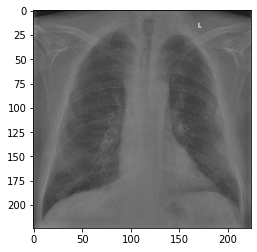

In [0]:
plt.figure()
plt.imshow(covid_train_dataset[0])
plt.grid(False)
plt.show()

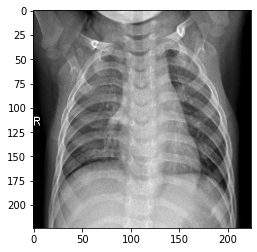

In [0]:
plt.figure()
plt.imshow(healthy_train_dataset[0])
plt.grid(False)
plt.show()

## Data Augmentation
Una vez tenemos el conjunto preprocesado y con la estructura de directorios adecuada, procedemos a la aumentación de datos.
En caso de pretender reproducir los datos, puede obtener el conjunto debidamente estructurado del siguiente enlace https://drive.google.com/drive/folders/1KG8aschyKw5VvmOffGCN9UaNwPn043QJ?usp=sharing, y modificar la ruta de cada partición devidamente.

In [0]:
train_path = "/content/drive/My Drive/SIGE DATASETS/DataSet_Covid_Normal_Xray_Classification/train"
validation_path = "/content/drive/My Drive/SIGE DATASETS/DataSet_Covid_Normal_Xray_Classification/validation"
test_path = "/content/drive/My Drive/SIGE DATASETS/DataSet_Covid_Normal_Xray_Classification/validation"

In [50]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                          rotation_range=45, 
                                                          zoom_range=0.2,
                                                          width_shift_range=0.2, 
                                                          height_shift_range=0.2, 
                                                          shear_range=0.2,
                                                          horizontal_flip=True, 
                                                          fill_mode="nearest")

train_augmented_data = datagen_train.flow_from_directory(
    train_path,
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=12345,
    follow_links=False,
    subset=None,
    interpolation="nearest",
)

Found 236 images belonging to 2 classes.


In [51]:
datagen_val = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_data = datagen_val.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=10,
    shuffle=False,
    seed=12345,
    follow_links=False,
    subset=None,
    interpolation="nearest",
)

Found 80 images belonging to 2 classes.


In [52]:
test_data = datagen_val.flow_from_directory(
    test_path,
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=10,
    shuffle=False,
    seed=12345,
    follow_links=False,
    subset=None,
    interpolation="nearest",
)

Found 80 images belonging to 2 classes.


## Aproximación CNN inicial

In [0]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Dropout, AveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
#create model
model = Sequential()
#add model layers
# conv + relu + conv + relu + pool
model.add(Conv2D(64, kernel_size=(7,7), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
# conv + relu + conv + relu + pool
model.add(Conv2D(64, kernel_size=(7,7), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
# conv + relu + conv + relu + pool
model.add(Conv2D(32, kernel_size=(7,7), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
# fc + relu
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization(epsilon=0.01))
model.add(Dropout(rate=0.5))
model.add(Dense(2, activation='softmax'))

In [55]:
# https://stackoverflow.com/questions/41665799/keras-model-summary-object-to-string
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_232 (Conv2D)          (None, 224, 224, 64)      9472      
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 112, 112, 64)      200768    
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 112, 112, 64)      36928     
_________________________________________________________________
average_pooling2d_6 (Average (None, 56, 56, 64)       

In [0]:
model.compile(loss="categorical_crossentropy", 
              optimizer=Nadam(),
              metrics=["accuracy"])

In [57]:
H1 = model.fit(train_augmented_data, 
                        steps_per_epoch=8,
                        validation_data=validation_data,
                        validation_steps=8,
                        epochs=50)

Epoch 1/50
8/8 [==============================] - 4s 464ms/step - loss: 0.7039 - accuracy: 0.6780 - val_loss: 0.5995 - val_accuracy: 0.5375
Epoch 2/50
8/8 [==============================] - 4s 482ms/step - loss: 0.5520 - accuracy: 0.7797 - val_loss: 0.4493 - val_accuracy: 0.9125
Epoch 3/50
8/8 [==============================] - 4s 444ms/step - loss: 0.5069 - accuracy: 0.8051 - val_loss: 0.3119 - val_accuracy: 0.8250
Epoch 4/50
8/8 [==============================] - 4s 438ms/step - loss: 0.4750 - accuracy: 0.8220 - val_loss: 0.5347 - val_accuracy: 0.6250
Epoch 5/50
8/8 [==============================] - 4s 446ms/step - loss: 0.3397 - accuracy: 0.8432 - val_loss: 0.2591 - val_accuracy: 0.8750
Epoch 6/50
8/8 [==============================] - 4s 446ms/step - loss: 0.4350 - accuracy: 0.8178 - val_loss: 0.8801 - val_accuracy: 0.6750
Epoch 7/50
8/8 [==============================] - 4s 442ms/step - loss: 0.4365 - accuracy: 0.8305 - val_loss: 0.4598 - val_accuracy: 0.8750
Epoch 8/50
8/8 [====

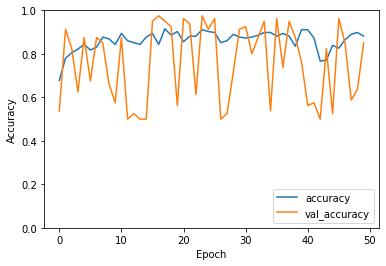

In [58]:
# Visualizamos valor de accuracy de entrenamiento
plt.plot(H1.history['accuracy'], label='accuracy')
plt.plot(H1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0., 1])
plt.legend(loc='lower right')

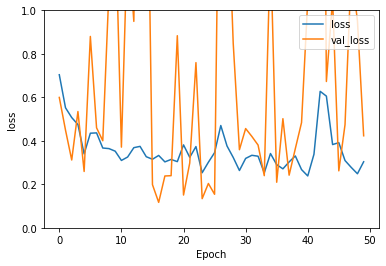

In [59]:
# Visualizamos valor de pérdida de entrenamiento
plt.plot(H1.history['loss'], label='loss')
plt.plot(H1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0., 1])
plt.legend(loc='upper right')

In [60]:
# Realizamos las predicciones sobre el conjunto de test, y 
# mostramos los resultados de la matriz de consufión, además
# de diversas métricas.
predictions = model.predict(test_data,
                     batch_size=10,
                     verbose=1)
y_pred = np.argmax(predictions, axis=1)
print(confusion_matrix(test_data.classes, y_pred))
print(classification_report(test_data.classes, y_pred, target_names = ['covid', 'healthy']))

8/8 [==============================] - 0s 33ms/step
[[28 12]
 [ 0 40]]
              precision    recall  f1-score   support

       covid       1.00      0.70      0.82        40
     healthy       0.77      1.00      0.87        40

    accuracy                           0.85        80
   macro avg       0.88      0.85      0.85        80
weighted avg       0.88      0.85      0.85        80



## Transfer-Learning
Para tratar de mejorar los resultados del anterior modelo, usaremos la técnica de transferencia de aprendizaje, empleando diversos modelos pre-entrenados para tratar de obtener el mejor resultado de clasificación posible.

### VGG16 Model

In [0]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam

#### Arquitectura
Modelo obtenido de https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/ .

In [0]:
# Instanciamos el modelo pre-entrenado con los pesos de imagenet
baseModel = VGG16(weights="imagenet", include_top=False, 
                  input_tensor=Input(shape=(224, 224, 3)))

# Definimos la parte no convolucional de la red
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Componemos el modelo con la parte convolucional pre-entrenada,
# junto a la nueva parte de la red densa definida
model = Model(inputs=baseModel.input, outputs=headModel)

# Congelamos las capas convolucionales para evitar que sean
# entrenadas, y poder usar así los filtros de características
# ya aprendidos.
for layer in baseModel.layers:
  layer.trainable = False

In [63]:
# https://stackoverflow.com/questions/41665799/keras-model-summary-object-to-string
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

#### Compilación del modelo

In [0]:
model.compile(loss="categorical_crossentropy", 
              optimizer=Nadam(),
              metrics=["accuracy"])

#### Entrenamiento del modelo

In [65]:
H2 = model.fit(train_augmented_data, 
                        steps_per_epoch=8,
                        validation_data=validation_data,
                        validation_steps=8,
                        epochs=50)

Epoch 1/50
8/8 [==============================] - 4s 500ms/step - loss: 0.7782 - accuracy: 0.5042 - val_loss: 0.6255 - val_accuracy: 0.7250
Epoch 2/50
8/8 [==============================] - 4s 440ms/step - loss: 0.6879 - accuracy: 0.5975 - val_loss: 0.5506 - val_accuracy: 0.8375
Epoch 3/50
8/8 [==============================] - 4s 439ms/step - loss: 0.5701 - accuracy: 0.7246 - val_loss: 0.4813 - val_accuracy: 0.9375
Epoch 4/50
8/8 [==============================] - 4s 438ms/step - loss: 0.5578 - accuracy: 0.7203 - val_loss: 0.4330 - val_accuracy: 0.9000
Epoch 5/50
8/8 [==============================] - 3s 434ms/step - loss: 0.5130 - accuracy: 0.8008 - val_loss: 0.3927 - val_accuracy: 0.8875
Epoch 6/50
8/8 [==============================] - 3s 434ms/step - loss: 0.4885 - accuracy: 0.7754 - val_loss: 0.3493 - val_accuracy: 0.9125
Epoch 7/50
8/8 [==============================] - 4s 475ms/step - loss: 0.4397 - accuracy: 0.8305 - val_loss: 0.3213 - val_accuracy: 0.9250
Epoch 8/50
8/8 [====

#### Visualización de resultados

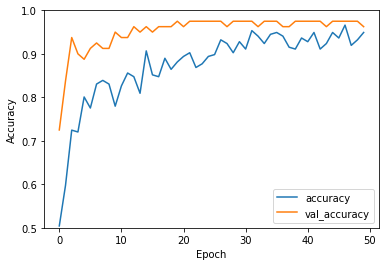

In [66]:
plt.plot(H2.history['accuracy'], label='accuracy')
plt.plot(H2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

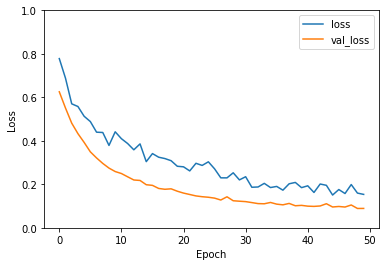

In [67]:
plt.plot(H2.history['loss'], label='loss')
plt.plot(H2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0., 1])
plt.legend(loc='upper right')

In [68]:
model.evaluate(test_data)

8/8 [==============================] - 1s 67ms/step - loss: 0.0891 - accuracy: 0.9625


[0.08911382406949997, 0.9624999761581421]

In [69]:
predictions = model.predict(test_data,
                     batch_size=10,
                     verbose=1)

8/8 [==============================] - 1s 66ms/step


In [0]:
y_pred = np.argmax(predictions, axis=1)

In [71]:
print(confusion_matrix(test_data.classes, y_pred))

[[39  1]
 [ 2 38]]


In [72]:
print(classification_report(test_data.classes, y_pred, target_names = ['covid', 'healthy']))

              precision    recall  f1-score   support

       covid       0.95      0.97      0.96        40
     healthy       0.97      0.95      0.96        40

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



### NasNetLarge Model

In [0]:
from tensorflow.keras.applications import NASNetLarge

In [0]:
baseModel = NASNetLarge(weights="imagenet", include_top=False, 
                  input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
  layer.trainable = False

In [75]:
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 96) 2592        input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_463 (Activation)     (None, 111, 111, 96) 0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [0]:
model.compile(loss="categorical_crossentropy", 
              optimizer=Nadam(),
              metrics=["accuracy"])

In [77]:
H3 = model.fit(train_augmented_data, 
                        steps_per_epoch=8,
                        validation_data=validation_data,
                        validation_steps=8,
                        epochs=50)

Epoch 1/50
8/8 [==============================] - 10s 1s/step - loss: 0.5383 - accuracy: 0.7839 - val_loss: 0.2000 - val_accuracy: 0.9625
Epoch 2/50
8/8 [==============================] - 5s 654ms/step - loss: 0.2293 - accuracy: 0.9110 - val_loss: 0.1665 - val_accuracy: 0.9625
Epoch 3/50
8/8 [==============================] - 6s 692ms/step - loss: 0.1545 - accuracy: 0.9492 - val_loss: 0.1722 - val_accuracy: 0.9625
Epoch 4/50
8/8 [==============================] - 5s 653ms/step - loss: 0.1144 - accuracy: 0.9534 - val_loss: 0.1986 - val_accuracy: 0.9625
Epoch 5/50
8/8 [==============================] - 5s 650ms/step - loss: 0.1597 - accuracy: 0.9492 - val_loss: 0.2031 - val_accuracy: 0.9625
Epoch 6/50
8/8 [==============================] - 5s 631ms/step - loss: 0.1870 - accuracy: 0.9280 - val_loss: 0.1318 - val_accuracy: 0.9500
Epoch 7/50
8/8 [==============================] - 5s 657ms/step - loss: 0.1095 - accuracy: 0.9703 - val_loss: 0.1843 - val_accuracy: 0.9625
Epoch 8/50
8/8 [======

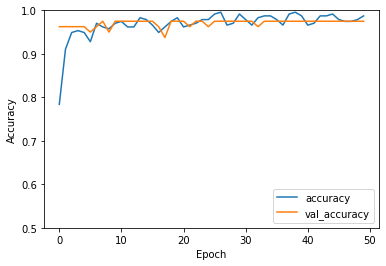

In [78]:
plt.plot(H3.history['accuracy'], label='accuracy')
plt.plot(H3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

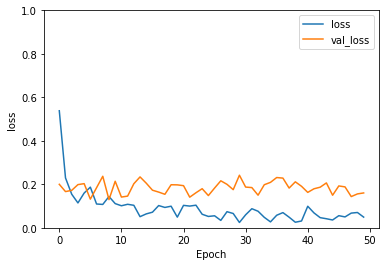

In [79]:
plt.plot(H3.history['loss'], label='loss')
plt.plot(H3.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0., 1])
plt.legend(loc='upper right')

In [80]:
predictions = model.predict(test_data,
                     batch_size=10,
                     verbose=1)
y_pred = np.argmax(predictions, axis=1)
print(confusion_matrix(test_data.classes, y_pred))
print(classification_report(test_data.classes, y_pred, target_names = ['covid', 'healthy']))

8/8 [==============================] - 1s 154ms/step
[[38  2]
 [ 0 40]]
              precision    recall  f1-score   support

       covid       1.00      0.95      0.97        40
     healthy       0.95      1.00      0.98        40

    accuracy                           0.97        80
   macro avg       0.98      0.97      0.97        80
weighted avg       0.98      0.97      0.97        80



### InceptionResNetV2 Model

In [0]:
from tensorflow.keras.applications import InceptionResNetV2

In [0]:
baseModel = InceptionResNetV2(weights="imagenet", include_top=False, 
                  input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
  layer.trainable = False

In [91]:
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_442 (Conv2D)             (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_408 (BatchN (None, 111, 111, 32) 96          conv2d_442[0][0]                 
__________________________________________________________________________________________________
activation_926 (Activation)     (None, 111, 111, 32) 0           batch_normalization_408[0][0]    
____________________________________________________________________________________________

In [0]:
model.compile(loss="categorical_crossentropy", 
              optimizer=Nadam(),
              metrics=["accuracy"])

In [84]:
H4 = model.fit(train_augmented_data, 
                        steps_per_epoch=8,
                        validation_data=validation_data,
                        validation_steps=8,
                        epochs=50)

Epoch 1/50
8/8 [==============================] - 7s 814ms/step - loss: 0.8678 - accuracy: 0.6398 - val_loss: 0.1143 - val_accuracy: 0.9750
Epoch 2/50
8/8 [==============================] - 4s 471ms/step - loss: 0.3844 - accuracy: 0.8390 - val_loss: 0.0746 - val_accuracy: 0.9750
Epoch 3/50
8/8 [==============================] - 4s 471ms/step - loss: 0.2324 - accuracy: 0.8941 - val_loss: 0.0540 - val_accuracy: 1.0000
Epoch 4/50
8/8 [==============================] - 4s 464ms/step - loss: 0.1571 - accuracy: 0.9449 - val_loss: 0.0523 - val_accuracy: 0.9875
Epoch 5/50
8/8 [==============================] - 4s 468ms/step - loss: 0.1490 - accuracy: 0.9364 - val_loss: 0.0442 - val_accuracy: 0.9875
Epoch 6/50
8/8 [==============================] - 4s 465ms/step - loss: 0.1998 - accuracy: 0.9068 - val_loss: 0.0264 - val_accuracy: 1.0000
Epoch 7/50
8/8 [==============================] - 4s 509ms/step - loss: 0.1416 - accuracy: 0.9364 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 8/50
8/8 [====

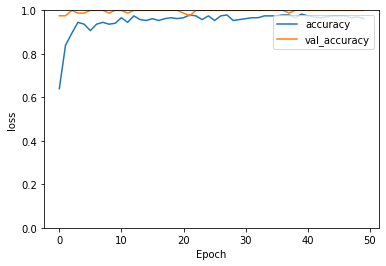

In [85]:
plt.plot(H4.history['accuracy'], label='accuracy')
plt.plot(H4.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0., 1])
plt.legend(loc='upper right')

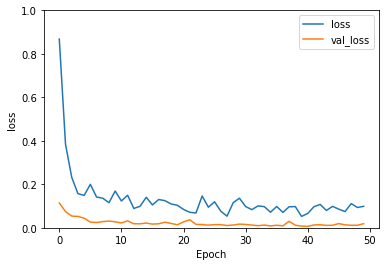

In [86]:
plt.plot(H4.history['loss'], label='loss')
plt.plot(H4.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0., 1])
plt.legend(loc='upper right')

In [87]:
predictions = model.predict(test_data,
                     batch_size=10,
                     verbose=1)
y_pred = np.argmax(predictions, axis=1)
print(confusion_matrix(test_data.classes, y_pred))
print(classification_report(test_data.classes, y_pred, target_names = ['covid', 'healthy']))

8/8 [==============================] - 1s 87ms/step
[[40  0]
 [ 0 40]]
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        40
     healthy       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



Como podemos observar, con este último modelo hemos conseguido obtener el mejor resultado para el conjunto de test, llegando al 100% de acierto de clasificación.